<a href="https://colab.research.google.com/github/JagnusEng/FaceNet/blob/main/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeanjagnus","key":"b8b8b7fde18d8154178417666595795b"}'}

In [1]:
# Create the Kaggle directory and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# Set permissions to avoid issues
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d quadeer15sh/lfw-facial-recognition --unzip -p /content/datasets/fw-facial-recognition --unzip

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/lfw-facial-recognition
License(s): CC0-1.0
100% 275M/275M [00:10<00:00, 32.4MB/s]
100% 275M/275M [00:10<00:00, 28.5MB/s]


In [4]:
!git clone https://github.com/timesler/facenet-pytorch.git

fatal: destination path 'facenet-pytorch' already exists and is not an empty directory.


In [5]:
pip install facenet-pytorch

In [14]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [16]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device)

In [17]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [18]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet-pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


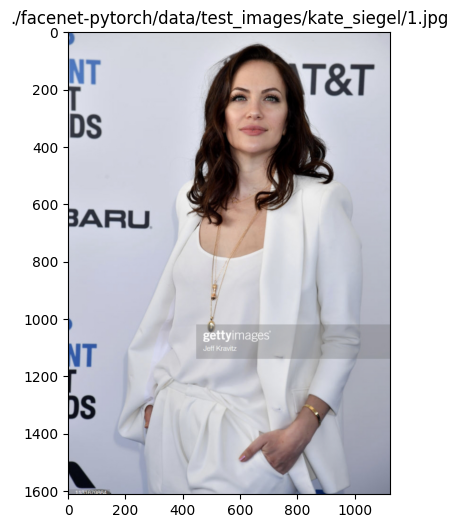

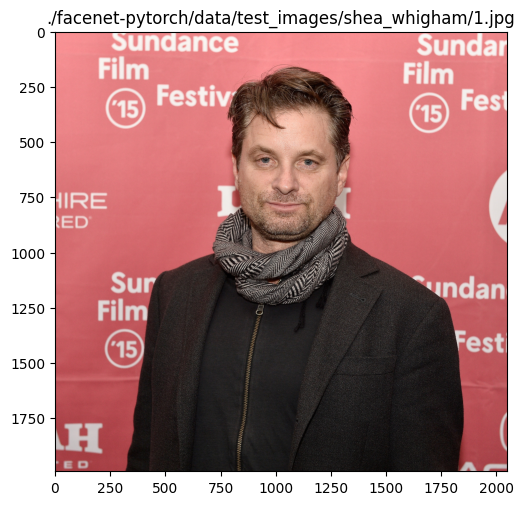

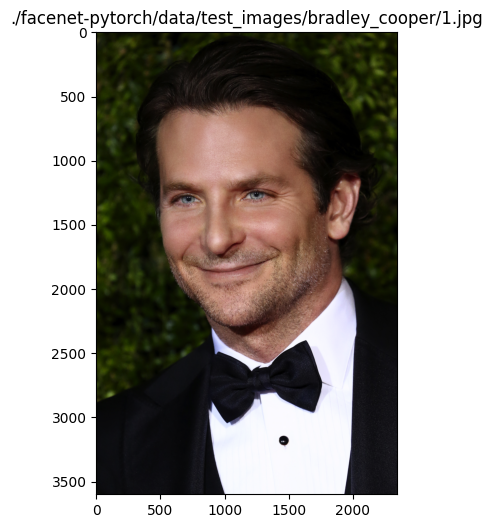

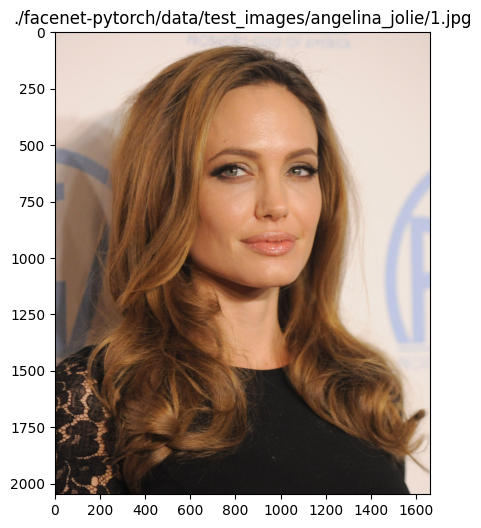

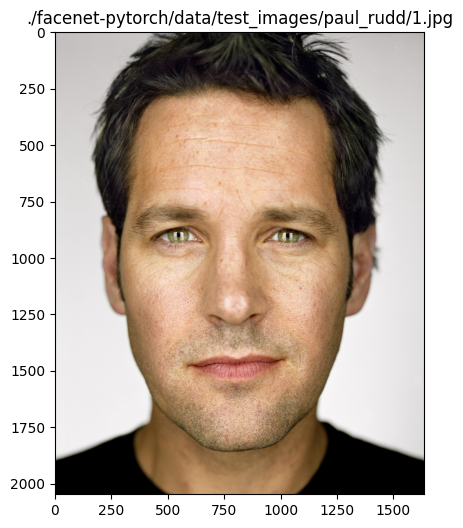

In [19]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function
def imgshow(title="", image = None, size = 6):
    if image.any():
      w, h = image.shape[0], image.shape[1]
      aspect_ratio = w/h
      plt.figure(figsize=(size * aspect_ratio,size))
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      plt.title(title)
      plt.show()
    else:
      print("Image not found")


for f in glob.glob('./facenet-pytorch/data/test_images/**/*.jpg', recursive=True):
    image = cv2.imread(f)
    imgshow(f, image)

In [20]:
aligned = []
names = []

for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999876
Face detected with probability: 0.999992


In [21]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [22]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
pd.DataFrame(dists, columns=names, index=names)

,angelina_jolie,bradley_cooper,kate_siegel,paul_rudd,shea_whigham
angelina_jolie,0.000000,1.447480,0.887728,1.434377,1.399073
bradley_cooper,1.447480,0.000000,1.313749,1.011980,1.038684
kate_siegel,0.887728,1.313749,0.000000,1.388993,1.379655
paul_rudd,1.434377,1.011980,1.388993,0.000000,1.104095
shea_whigham,1.399073,1.038684,1.379655,1.104095,0.000000
